In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import datetime as dt
from datetime import datetime   
from sqlalchemy import create_engine

In [2]:
# connecting to the database
cnx = create_engine('mysql+pymysql://root:@localhost/dukapaq_db')    

In [3]:
company_details=pd.read_sql('SELECT * FROM companies', cnx)
#company_details.to_excel('reg.xlsx', index=False)

### Daily Transactions

In [4]:
df_transactions=pd.read_sql("SELECT * FROM transactions", cnx)
#df_transactions.query('company_id==3')
df_transactions['created_at']=pd.to_datetime(df_transactions['created_at'])
df_transactions['transaction_month']=pd.to_datetime(df_transactions['created_at']).dt.strftime('%B')
df_transactions['transaction_day']=pd.to_datetime(df_transactions['created_at']).dt.day
df_transactions['month_day'] = df_transactions['transaction_month'] + ', ' + df_transactions['transaction_day'].astype(str)


###### Data cleaning

In [5]:
df_transactions['company_id'].nunique()

6

In [6]:
df_transactions['company_id'].unique()

array([ 1., nan,  2.,  4.,  3.,  6.,  9.])

In [7]:
# DROPPING dummy data
values_to_drop = [1, 2, 7, 8]
df_transactions = df_transactions[~df_transactions['company_id'].isin(values_to_drop)]
# create a new column with the day and month name
#df_transactions['day_month'] = df_transactions['created_at'].dt.strftime('%A, %B')
df_transactions.head(2)

,id,tran_type,account_id,amount,description,debit,credit,balance,date,customer_id,supplier_id,order_id,created_at,updated_at,company_id,transaction_month,transaction_day,month_day
6,7,Income,1,197030.0,POS order,0,1,1001303.0,2022-12-07,5001.0,None,100008.0,2022-12-07 03:08:28,2022-12-07 03:08:28,NaN,December,7,"December, 7"
7,8,Expense,1,2000.0,Electricity,1,0,999303.0,2022-12-06,NaN,None,NaN,2022-12-07 03:24:08,2022-12-07 03:24:08,NaN,December,7,"December, 7"


In [8]:
# Dropping rows with null values in company_id
df_transactions.isnull().sum()

id                    0
tran_type             0
account_id            0
amount                0
description           0
debit                 0
credit                0
balance               1
date                  0
customer_id           7
supplier_id          66
order_id             11
created_at            0
updated_at            0
company_id           11
transaction_month     0
transaction_day       0
month_day             0
dtype: int64

In [9]:
df_transactions = df_transactions.dropna(subset=['company_id'])
df_transactions.head(1)

,id,tran_type,account_id,amount,description,debit,credit,balance,date,customer_id,supplier_id,order_id,created_at,updated_at,company_id,transaction_month,transaction_day,month_day
35,55,Income,18,2130.0,POS order,0,1,2130.0,2023-02-06,5001.0,None,1.675680e+09,2023-02-06 19:43:24,2023-02-06 19:43:24,4.0,February,6,"February, 6"


In [10]:
business_settings=pd.read_sql('SELECT * FROM business_settings',cnx)
business_settings.head(1)

,app_minimum_version_ios,id,company_id,shop_logo,pagination_limit,currency,shop_name,shop_address,shop_phone,shop_email,footer_text,country,stock_limit,time_zone,vat_reg_no,created_at,updated_at
0,None,1,2,None,10,Kes,Red Flags Wines and Spirits,"NAIROBI,KENYA",0745683466,info@mikedee.com,Red Flags Wines and Spirits,KE,5,None,P0HJY678TDF,2022-11-26 18:43:15,2022-11-26 18:43:15


In [37]:
daily_company_transactions=df_transactions.groupby(['transaction_month','transaction_day','company_id'])['amount'].sum().reset_index()
daily_company_income=pd.merge(daily_company_transactions, business_settings[['shop_name','company_id']], on='company_id')
daily_company_income
# group the data frame by transaction_day and create a new data frame with the groups
grouped = daily_company_income.groupby('transaction_day')
DailyCompanyTransaction = pd.concat([grouped.get_group(x) for x in grouped.groups], keys=grouped.groups.keys())
#DailyCompanyTransaction.to_excel('active_companies.xlsx', index=False)
DailyCompanyTransaction

transaction_month  transaction_day  company_id   amount  \
6  0           February                6         3.0   6485.0   
   11          February                6         4.0  23799.6   
7  1           February                7         3.0   3565.0   
8  2           February                8         3.0   2725.0   
   14          February                8         6.0    250.0   
9  3           February                9         3.0  14865.0   
   15          February                9         9.0    250.0   
10 4           February               10         3.0   2625.0   
   16          February               10         9.0    500.0   
11 5           February               11         3.0   3565.0   
   17          February               11         9.0    250.0   
13 18          February               13         9.0   1350.0   
15 6           February               15         3.0   9597.5   
16 7           February               16         3.0   1942.5   
17 12          February               17         4.0    550.0   
18 8           February               18         3.0   4672.5   
   13          February               18         4.0   9421.2   
21 9           February               21         3.0   7890.0   
22 10          February               22         3.0   3630.0   

                           shop_name  
6  0                Deneric printing  
   11     Blackspot Wines and Spirit  
7  1                Deneric printing  
8  2                Deneric printing  
   14                MAX ELECTRONICS  
9  3                Deneric printing  
   15  KB LOVE & LAGERS LIQUOR STORE  
10 4                Deneric printing  
   16  KB LOVE & LAGERS LIQUOR STORE  
11 5                Deneric printing  
   17  KB LOVE & LAGERS LIQUOR STORE  
13 18  KB LOVE & LAGERS LIQUOR STORE  
15 6                Deneric printing  
16 7                Deneric printing  
17 12     Blackspot Wines and Spirit  
18 8                Deneric printing  
   13     Blackspot Wines and Spirit  
21 9                Deneric printing  
22 10               Deneric printing

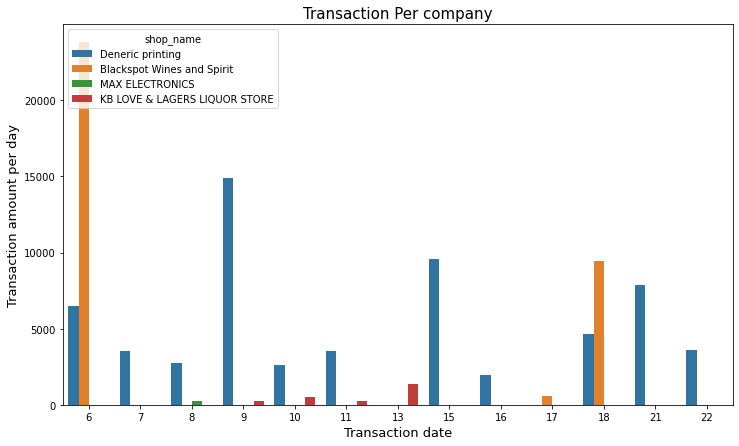

In [38]:
plt.subplots(figsize=(12, 7))
sns.barplot(data=daily_company_income, x='transaction_day', y='amount', hue='shop_name')
plt.title("Transaction Per company", size=15)
plt.ylabel("Transaction amount per day", size=13)
#plt.xticks(rotation='vertical', size=10)
plt.xlabel("Transaction date", size=13)
# save the plot to a PNG file
plt.savefig('company_transactions.png')
plt.show()

###### Daily_transaction_per_company

In [13]:
#Deneric_transactions
daily_transactions=df_transactions.query('company_id==3') #.sort_values(by='month_day', ascending=True, inplace=True)
daily_transactions.head(2)

,id,tran_type,account_id,amount,description,debit,credit,balance,date,customer_id,supplier_id,order_id,created_at,updated_at,company_id,transaction_month,transaction_day,month_day
41,61,Income,1,1500.0,POS order,0,1,1500.0,2023-02-06,5001.0,None,1.675682e+09,2023-02-06 20:11:26,2023-02-06 20:11:26,3.0,February,6,"February, 6"
42,62,Income,1,1100.0,POS order,0,1,1100.0,2023-02-06,5001.0,None,1.675682e+09,2023-02-06 20:17:02,2023-02-06 20:17:02,3.0,February,6,"February, 6"


In [14]:
daily_trans=daily_transactions.groupby(['company_id','transaction_month','transaction_day','tran_type'])['amount'].sum().reset_index()
company_daily_trans=daily_trans.rename(columns={'transaction_month':'transaction month','transaction_day':'transaction day','tran_type':'Transaction type made'})
#Deneric Daily Transactions
company_daily_trans.query('company_id==3')
#deneric_daily_trans.to_excel('daily_transactions.xlsx', index=False)


,company_id,transaction month,transaction day,Transaction type made,amount
0,3.0,February,6,Income,6485.0
1,3.0,February,7,Income,3565.0
2,3.0,February,8,Income,2725.0
3,3.0,February,9,Income,14865.0
4,3.0,February,10,Income,2625.0
5,3.0,February,11,Income,3565.0
6,3.0,February,15,Income,9597.5
7,3.0,February,16,Income,1942.5
8,3.0,February,18,Income,4672.5
9,3.0,February,21,Income,7890.0


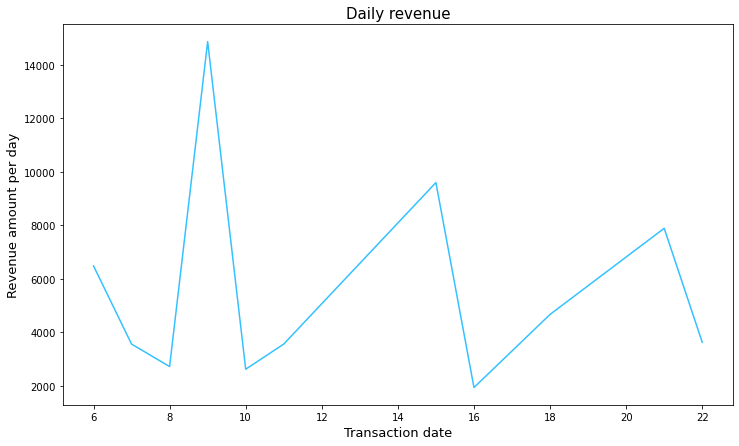

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))

sns.lineplot(data=company_daily_trans, y='amount', x='transaction day', color='#33C1FF')
#sns.lineplot(data=daily_orders, y='collected_cash', x='order_date', color='#33C1FF', ax=ax)

plt.title("Daily revenue", size=15)
plt.ylabel("Revenue amount per day", size=13)
#plt.xticks(rotation='vertical', size=10)
plt.xlabel("Transaction date", size=13)
# save the plot to a PNG file
plt.savefig('daily_revenue.png')
plt.show()


#### Total average transactions

In [16]:
#deneric
company_daily_trans_average_transactions = company_daily_trans['amount'].mean()
company_daily_trans_average_transactions

5596.590909090909

#### Inventory Total Amount

In [17]:
df_Products=pd.read_sql('SELECT * FROM products', cnx)

In [18]:

def extract_id_values(row):
    data_list = pd.io.json.loads(row)
    values = [d['id'] for d in data_list]
    return pd.Series(values)

temp_df = df_Products['category_ids'].apply(extract_id_values).apply(pd.Series)
temp_df = temp_df.rename(columns = lambda x : 'id_values_' + str(x))
result = pd.concat([df_Products, temp_df], axis=1)
result.head(2)

,id,name,product_code,unit_type,unit_value,brand,category_ids,purchase_price,selling_price,discount_type,...,tax,quantity,image,order_count,supplier_id,created_at,updated_at,company_id,id_values_0,id_values_1
0,1,Banana,347653,1,878.0,1,"[{""id"":""1"",""position"":""1""},{""id"":""2"",""position...",18.0,747.0,amount,...,0.0,457,def.png,24,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,1,2
1,2,Milk,974689,1,799.0,1,"[{""id"":""1"",""position"":""1""},{""id"":""2"",""position...",130.0,808.0,amount,...,0.0,251,def.png,26,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,1,2


In [19]:
# creating another column 'id_values_0' so that I ccan join with another table
df_categories=pd.read_sql("SELECT * FROM categories", cnx)
df_categories['id_values_0']=df_categories['id']
#deneric_categoriess=df_categories.query('company_id==3')
#deneric_categoriess
df_categories.head(3)

,id,name,parent_id,position,status,image,created_at,updated_at,company_id,id_values_0
0,1,Fruits,0,0,1,2022-11-30-63876a81a5abc.png,2022-11-30 23:36:49,2023-01-20 05:03:40,1.0,1
1,2,Milk,0,0,1,2023-01-20-63c9a18be7177.png,2022-12-08 16:20:19,2023-01-20 05:01:15,1.0,2
2,3,golden milk,2,1,1,def.png,2022-12-08 16:21:34,2022-12-08 16:21:34,1.0,3


In [20]:
#result.info()

In [21]:
# JOining tables
result['id_values_0'] = result['id_values_0'].astype(int)
total_inventory_amount = pd.merge(df_categories, result, on='id_values_0', how='inner')
total_inventory_amount.head(2)

,id_x,name_x,parent_id,position,status,image_x,created_at_x,updated_at_x,company_id_x,id_values_0,...,discount,tax,quantity,image_y,order_count,supplier_id,created_at_y,updated_at_y,company_id_y,id_values_1
0,1,Fruits,0,0,1,2022-11-30-63876a81a5abc.png,2022-11-30 23:36:49,2023-01-20 05:03:40,1.0,1,...,10.0,0.0,457,def.png,24,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,2
1,1,Fruits,0,0,1,2022-11-30-63876a81a5abc.png,2022-11-30 23:36:49,2023-01-20 05:03:40,1.0,1,...,10.0,0.0,251,def.png,26,1.0,2022-11-26 20:56:08,2023-01-21 15:19:35,1.0,2


In [22]:
inventory_amount=total_inventory_amount[['name_x','name_y','quantity','order_count','company_id_x']]
#Renaming columns
# deneric_inventory_amount.columns('Category','Product','Quantity','Orders made','Company_id')
inventory_amount_renamed=inventory_amount.rename(columns={'name_x': 'categories', 'name_y': 'products','order_count':'orders made','company_id_x':'company_id'})
inventory_amount_renamed

,categories,products,quantity,orders made,company_id
0,Fruits,Banana,457,24,1.0
1,Fruits,Milk,251,26,1.0
2,Fruits,Oranges,5,7,1.0
3,Fruits,Chicken,114,3,1.0
4,Fruits,tomato,40,9,1.0
...,...,...,...,...,...
206,Vodka,Chrome vodka 250ml,0,2,9.0
207,Ice cream Vanilla,Vanilla ice cream,4,0,86.0
208,FINISHING,A4 LAMINATION,1000,0,3.0
209,Airforce,Airforce 1 white,40,0,89.0


In [23]:
#Deneric revenue
company_inventory_amount=inventory_amount_renamed.query('company_id==3')
company_inventory_amount[['categories','products','quantity','orders made','company_id']]


#deneric_inventory_amount.to_excel('deneric_inventory.xlsx', index=False)

,categories,products,quantity,orders made,company_id
86,DRINKWARE,MAISON JAR,100,0,3.0
87,DRINKWARE,THERMO FLASK TEMPERATURE,1000,0,3.0
88,DRINKWARE,ALUMINIUM WATER BOTTLE,1000,0,3.0
89,DRINKWARE,PLASTIC WATER BOTTLE,1000,0,3.0
90,DRINKWARE,THERMO MUG,1000,0,3.0
91,DRINKWARE,MAGIC MUG,995,1,3.0
92,DRINKWARE,NORMAL MUG,1000,0,3.0
93,PRINTING,TSHIRT/JERSEY PRINTING,1000,0,3.0
94,PRINTING,STYLUS EXECUTIVE PEN,1000,0,3.0
95,PRINTING,A5 NOTEBOOK,1000,0,3.0


#### Inventory Total Revenue Amount

In [24]:
inventory_amount_revenue=pd.merge(company_inventory_amount, daily_transactions, on='company_id', how='inner')
#total_inventory_amount_revenue = inventory_amount_revenue.groupby('order_count').sum['amount'].reset_index(level=0, name='total_amount')
inventory_amount_revenue['total_amount']=inventory_amount_revenue['amount']*inventory_amount_revenue['orders made']
total_inventory_amount_revenue=inventory_amount_revenue[['company_id','categories','products', 'orders made','amount','total_amount','company_id']]
total_inventory_amount_revenue.query('company_id==3').head(3)

,company_id,categories,products,orders made,amount,total_amount,company_id
0,3.0,DRINKWARE,MAISON JAR,0,1500.0,0.0,3.0
1,3.0,DRINKWARE,MAISON JAR,0,1100.0,0.0,3.0
2,3.0,DRINKWARE,MAISON JAR,0,3885.0,0.0,3.0


#### payment data

In [25]:
df_accounts=pd.read_sql('SELECT * FROM accounts', cnx)
df_accounts
deneric_accounts=df_accounts.query('company_id==3')
deneric_accounts[['account','description','total_in']]

,account,description,total_in
14,CASH,money on the counter,12925.0
15,LIPA NA MPESA,Till money,20002.5


In [26]:
deneric_total_inventory_amount_revenue=total_inventory_amount_revenue.query('company_id==3')
deneric_total_inventory_amount_revenue.head(3)

,company_id,categories,products,orders made,amount,total_amount,company_id
0,3.0,DRINKWARE,MAISON JAR,0,1500.0,0.0,3.0
1,3.0,DRINKWARE,MAISON JAR,0,1100.0,0.0,3.0
2,3.0,DRINKWARE,MAISON JAR,0,3885.0,0.0,3.0


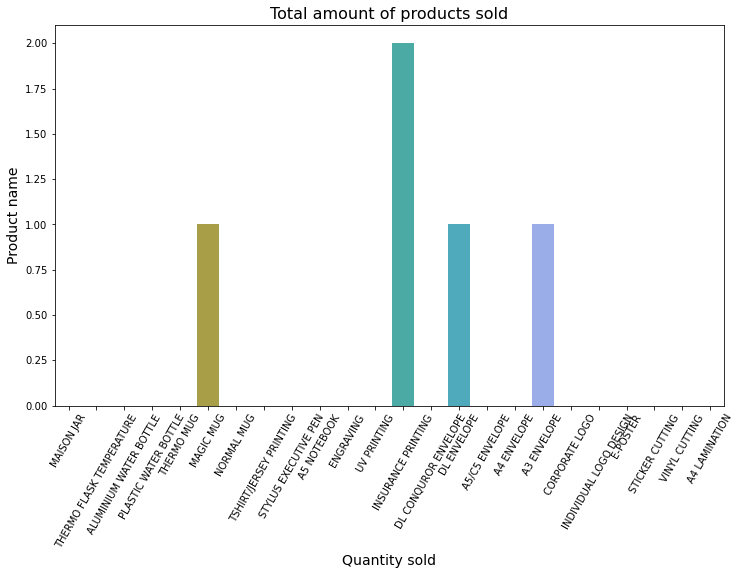

In [27]:
plt.subplots(figsize=(12, 7))
sns.barplot(data=deneric_total_inventory_amount_revenue, x='products', y='orders made')
plt.title("Total amount of products sold", size=16)
plt.xlabel("Quantity sold", size=14)
plt.xticks(rotation=60, size=10)
plt.ylabel("Product name", size=14)
plt.savefig("product_sold.png")
plt.show()

#### Amount per type

### Daily account registration

In [28]:
registered_accounts=pd.read_sql('SELECT * FROM companies',cnx)
registered_accounts.head(3)

,id,company_name,sub_domain_prefix,created_at,updated_at
0,2,REDFLAG Wines and Spirit,redflag_wines_and_spirit,2023-01-26 21:47:47,2023-01-26 21:47:47
1,3,Deneric Printing,Deneric_printing,2023-01-26 21:47:47,2023-01-26 21:47:47
2,4,BLACKSPOT Wines and Spirit,blackspot_wines_and_spirit,2023-01-26 21:47:47,2023-01-26 21:47:47


In [35]:
registered_accounts['created_at']=pd.to_datetime(registered_accounts['created_at'])
registered_accounts['month_registered']=pd.to_datetime(registered_accounts['created_at']).dt.strftime('%B')
registered_accounts['day_registered']=pd.to_datetime(registered_accounts['created_at']).dt.day
#registered_accounts['month_day'] = registered_accounts['month_registered'] + ', ' + registered_accounts['day_registered'].astype(str)
registered_accounts['month_day']=pd.to_datetime(registered_accounts['created_at']).dt.strftime('%d %B')
# DROPPING dummy data
values_to_dropp = [2, 7, 8, 65, 69, 67, 82, 76, 71, 72, 73, 74, 75]
new_registered_accounts = registered_accounts[~registered_accounts['id'].isin(values_to_dropp)]


new_registered_accounts.head(3)

,id,company_name,sub_domain_prefix,created_at,updated_at,month_registered,day_registered,month_day
1,3,Deneric Printing,Deneric_printing,2023-01-26 21:47:47,2023-01-26 21:47:47,January,26,26 January
2,4,BLACKSPOT Wines and Spirit,blackspot_wines_and_spirit,2023-01-26 21:47:47,2023-01-26 21:47:47,January,26,26 January
3,5,Agape Shop,agape_shop,2023-01-26 21:47:47,2023-01-26 21:47:47,January,26,26 January


In [36]:
#daily_trans=daily_transactions.groupby(['company_id','transaction_month','transaction_day','tran_type'])['amount'].sum().reset_index()
daily_registered_accounts=new_registered_accounts.groupby(['month_day'])['day_registered'].size().reset_index()
daily_registered_accounts.sort_values(by='month_day')
# daily_registered_accounts.to_excel('sss.xlsx', index=False)

,month_day,day_registered
0,19 February,3
1,20 February,13
2,21 February,6
3,22 February,3
4,26 January,41


In [ ]:
plt.subplots(figsize=(9,6))
sns.lineplot(data=daily_registered_accounts, x='month_day', y='day_registered', )
plt.title('Account Downloads Per Day', size=15)

### Monthly account registration

In [ ]:
monthly_registered_accounts=new_registered_accounts.groupby(['month_registered'])['day_registered'].size().reset_index()
monthly_registered_accounts


#### Weeklty_account_registration

In [ ]:
# #registered_accounts.set_index('day_registered', inplace=True)
# registered_accountss['created_at']=pd.to_datetime(registered_accountss['created_at'])
# weekly_registered_accounts=registered_accounts.groupby(['month_day'])['created_at'].resample('W').size().reset_index()
# weekly_registered_accounts
# # df_weekly = registered_accounts.resample('W').size()
# # df_weekly.head()

In [ ]:
# registered_accounts['WeekDate'] = registered_accounts.apply(lambda row: row['created_at'] - dt.timedelta(days=row['created_at'].weekday()), axis=1)
# registered_accounts.head(2)

In [ ]:
# # weekly_registered_accounts=registered_accounts.groupby(['month_day'])['WeekDate'].resample('W').size().reset_index()
# # weekly_registered_accounts

# registered_accounts.set_index('created_at', inplace=True)

# # Resample the dataframe to group by week and calculate the sum of values for each week
# df_weekly = registered_accounts.resample('W').sum()
